# This is a notebook for exploring character representations. 

Possible things to capture are:

* The letter occurrences
* Letter case
* Letter shape
* Phonetic and mouth shape relations
* Relationship between symbols, numbers, etc.
* Relationship between characters of different languages

# Steps
1. Write your own file reader
2. Write your own similarity
3. Write a testing suite for comparison
4. Get character embeddings from Fasttext

In [1]:
from gensim.models.poincare import PoincareModel
from gensim.models import KeyedVectors
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
case_relations = [
    ('a', 'lower'), ('b', 'lower'), ('c', 'lower'), ('ç', 'lower'),
    ('d', 'lower'), ('e', 'lower'), ('f', 'lower'), ('g', 'lower'), 
    ('ğ', 'lower'), ('h', 'lower'), ('i', 'lower'), ('ı', 'lower'), 
    ('j', 'lower'), ('k', 'lower'), ('l', 'lower'), ('m', 'lower'),
    ('n', 'lower'), ('o', 'lower'), ('ö', 'lower'), ('p', 'lower'), 
    ('r', 'lower'), ('s', 'lower'), ('ş', 'lower'), ('t', 'lower'), 
    ('u', 'lower'), ('ü', 'lower'), ('v', 'lower'), ('y', 'lower'),
    ('z', 'lower'), ('A', 'upper'), ('B', 'upper'), ('C', 'upper'), 
    ('Ç', 'upper'), ('D', 'upper'), ('E', 'upper'), ('F', 'upper'), 
    ('G', 'upper'), ('Ğ', 'upper'), ('H', 'upper'), ('İ', 'upper'), 
    ('I', 'upper'), ('J', 'upper'), ('K', 'upper'), ('L', 'upper'),
    ('M', 'upper'), ('N', 'upper'), ('O', 'upper'), ('Ö', 'upper'), 
    ('P', 'upper'), ('R', 'upper'), ('S', 'upper'), ('Ş', 'upper'), 
    ('T', 'upper'), ('U', 'upper'), ('Ü', 'upper'), ('V', 'upper'),
    ('Y', 'upper'), ('Z', 'upper'),
    ('lower', 'case'), ('upper', 'case')
]

is_a_relations = [
    ('A', 'a'), ('B', 'b'), ('C', 'c'), ('Ç', 'ç'), ('D', 'd'), ('E', 'e'),
    ('F', 'f'), ('G', 'g'), ('Ğ', 'ğ'), ('H', 'h'), ('İ', 'i'),
    ('I', 'ı'), ('J', 'j'), ('K', 'k'), ('L', 'l'), ('M', 'm'),
    ('N', 'n'), ('O', 'o'), ('Ö', 'ö'), ('P', 'p'), ('R', 'r'),
    ('S', 's'), ('Ş', 'ş'), ('T', 't'), ('U', 'u'), ('Ü', 'ü'),
    ('V', 'v'), ('Y', 'y'), ('Z', 'z')
]

In [3]:
phonetic_relations = [('kalın_ünlü', 'ünlü'), ('ince_ünlü', 'ünlü'),
                      ('düz_ünlü', 'ünlü'), ('yuvarlak_ünlü', 'ünlü'),
                      ('dar_ünlü', 'ünlü'), ('geniş_ünlü', 'ünlü'),
                      ('sert_ünsüz', 'ünsüz'), ('yumuşak_ünsüz', 'ünsüz'),
                      ('sürekli_ünsüz', 'ünsüz'), ('süreksiz_ünsüz', 'ünsüz'),
                      ('lips', 'voice'), ('teeth', 'voice'), ('palate', 'voice'),
                      ('throat', 'voice'),
                      ('a', 'kalın_ünlü'), ('ı', 'kalın_ünlü'), ('o', 'kalın_ünlü'), 
                      ('u', 'kalın_ünlü'),
                      ('e', 'ince_ünlü'), ('i', 'ince_ünlü'),('ö', 'ince_ünlü'), 
                      ('ü', 'ince_ünlü'), 
                      ('a', 'düz_ünlü'), ('e', 'düz_ünlü'), ('ı', 'düz_ünlü'), 
                      ('i', 'düz_ünlü'),
                      ('o', 'yuvarlak_ünlü'), ('ö', 'yuvarlak_ünlü'), ('u', 'yuvarlak_ünlü'), 
                      ('ü', 'yuvarlak_ünlü'),
                      ('ı', 'dar_ünlü'), ('i', 'dar_ünlü'), ('u', 'dar_ünlü'), 
                      ('ü', 'dar_ünlü'),
                      ('a', 'geniş_ünlü'), ('e', 'geniş_ünlü'), ('o', 'geniş_ünlü'), 
                      ('ö', 'geniş_ünlü'),
                      ('f', 'sert_ünsüz'), ('h', 'sert_ünsüz'), ('s', 'sert_ünsüz'),
                      ('ş', 'sert_ünsüz'), ('ç', 'sert_ünsüz'), ('k', 'sert_ünsüz'),
                      ('p', 'sert_ünsüz'), ('t', 'sert_ünsüz'), 
                      ('b', 'yumuşak_ünsüz'), ('c', 'yumuşak_ünsüz'), ('d', 'yumuşak_ünsüz'),
                      ('ğ', 'yumuşak_ünsüz'), ('j', 'yumuşak_ünsüz'), ('l', 'yumuşak_ünsüz'),
                      ('m', 'yumuşak_ünsüz'), ('n', 'yumuşak_ünsüz'), ('r', 'yumuşak_ünsüz'),
                      ('v', 'yumuşak_ünsüz'), ('y', 'yumuşak_ünsüz'), ('z', 'yumuşak_ünsüz'),
                      ('g', 'yumuşak_ünsüz'),
                      ('f', 'sürekli_ünsüz'), ('h', 'sürekli_ünsüz'), ('s', 'sürekli_ünsüz'),
                      ('ş', 'sürekli_ünsüz'), ('ğ', 'sürekli_ünsüz'), ('j', 'sürekli_ünsüz'),
                      ('l', 'sürekli_ünsüz'), ('m', 'sürekli_ünsüz'), ('n', 'sürekli_ünsüz'),
                      ('r', 'sürekli_ünsüz'), ('v', 'sürekli_ünsüz'), ('y', 'sürekli_ünsüz'),
                      ('z', 'sürekli_ünsüz'),
                      ('ç', 'süreksiz_ünsüz'), ('k', 'süreksiz_ünsüz'), ('p', 'süreksiz_ünsüz'),
                      ('t', 'süreksiz_ünsüz'), ('b', 'süreksiz_ünsüz'), ('c', 'süreksiz_ünsüz'),
                      ('d', 'süreksiz_ünsüz'), ('g', 'süreksiz_ünsüz'),
                      ('f', 'lips'), ('p', 'lips'), ('m', 'lips'), 
                      ('v', 'lips'), ('b', 'lips'),
                      ('s', 'teeth'), ('ş', 'teeth'), ('ç', 'teeth'),
                      ('t', 'teeth'), ('j', 'teeth'), ('l', 'teeth'),
                      ('n', 'teeth'), ('r', 'teeth'), ('z', 'teeth'),
                      ('c', 'teeth'), ('d', 'teeth'),
                      ('k', 'palate'), ('ğ', 'palate'), ('y', 'palate'),
                      ('g', 'palate'),
                      ('h', 'throat')
                     ]

In [4]:
numeric_relations = [('0', 'digit'), ('1', 'digit'), ('2', 'digit'), 
                     ('3', 'digit'), ('4', 'digit'), ('5', 'digit'),
                     ('6', 'digit'), ('7', 'digit'), ('8', 'digit'), 
                     ('9', 'digit')]

In [5]:
punctuations = [
    ('.', 'punc'), (',', 'punc'), (':', 'punc'), (';', 'punc'),
    (';', 'punc'), ('...', 'punc'), ('?', 'punc'), ('!', 'punc'),
    ('"', 'punc'), ('\'', 'punc'), ('(', 'punc'), (')', 'punc'),
    ('-', 'punc'), ('/', 'punc'), ('\\', 'punc'), ('[', 'punc'),
    (']', 'punc'),
]

In [6]:
relations = case_relations + is_a_relations + phonetic_relations + numeric_relations + punctuations

In [7]:
def visualize_embeddings(model, feature_size):
    words = []
    embedding = np.array([])
    i = 0
    for word in model.kv.vocab:
        words.append(word)
        embedding = np.append(embedding, model.kv[word])
        i += 1

    embedding = embedding.reshape(len(model.kv.vocab), feature_size)
    tsne = TSNE(perplexity=30.0, n_components=2, init='pca', n_iter=5000)
    low_dim_embedding = tsne.fit_transform(embedding)

    plt.figure(figsize=(20, 20))
    for i, label in enumerate(words):
        x, y = low_dim_embedding[i, :]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

In [8]:
feature_size = 16
char_model = PoincareModel(relations, size=feature_size, negative=20)
char_model.train(epochs=100)

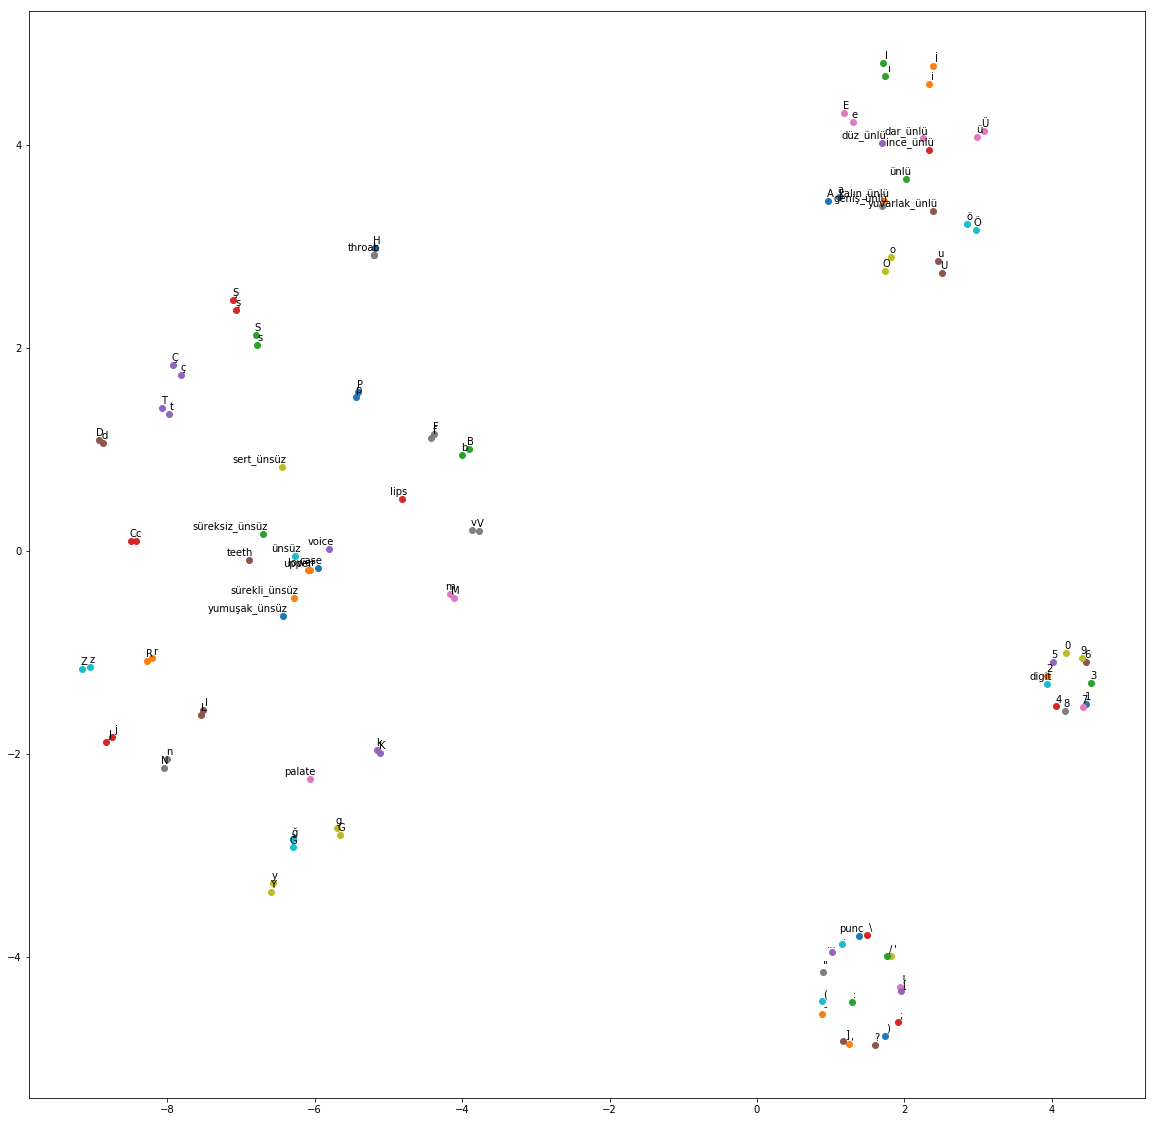

In [9]:
visualize_embeddings(char_model, feature_size)

In [10]:
char_model.kv.most_similar("a")

[('a', 0.0),
 ('kalın_ünlü', 1.744073711135486),
 ('A', 1.804876516822938),
 ('geniş_ünlü', 1.9130320996453434),
 ('düz_ünlü', 1.9241755182290352),
 ('ünlü', 2.1683983574010868),
 ('dar_ünlü', 2.5148707463381417),
 ('ince_ünlü', 2.608980168899683),
 ('yuvarlak_ünlü', 2.6272963580133277),
 ('case', 2.849939962075816)]

In [11]:
char_model.kv.save_word2vec_format("models\\tr_char_"+str(feature_size)+".model")

In [12]:
assert char_model.kv.similarity('a', 'e') > char_model.kv.similarity('a', 'b')
assert char_model.kv.similarity('a', 'A') > char_model.kv.similarity('a', 'i')
assert char_model.kv.similarity('a', 'lower') > char_model.kv.similarity('a', 'upper')

assert char_model.kv.similarity('ç', 't') > char_model.kv.similarity('ç', 'i')
assert char_model.kv.similarity('ç', 'Ç') > char_model.kv.similarity('ç', 'd')
assert char_model.kv.similarity('ç', 'lower') > char_model.kv.similarity('ç', 'upper')

AssertionError: 